### Examine the Data

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# define the plot size default
from pylab import rcParams
rcParams['figure.figsize'] = (12,5)

# load specific forecasting tools
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tools.eval_measures import mse,rmse

# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")


# Read the dataset
money_df = pd.read_csv('M2SLMoneyStock.csv', index_col=0, parse_dates=True)
money_df.index.freq = 'MS'
spending_df = pd.read_csv('PCEPersonalSpending.csv', index_col=0, parse_dates=True)
spending_df.index.freq = 'MS'
df = money_df.join(spending_df)
df.head()


,Money,Spending
Date,,
1995-01-01,3492.4,4851.2
1995-02-01,3489.9,4850.8
1995-03-01,3491.1,4885.4
1995-04-01,3499.2,4890.2
1995-05-01,3524.2,4933.1


In [14]:
df.isna().sum()

Money       0
Spending    0
dtype: int64

In [15]:
len(df)

252

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 252 entries, 1995-01-01 to 2015-12-01
Freq: MS
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Money     252 non-null    float64
 1   Spending  252 non-null    float64
dtypes: float64(2)
memory usage: 14.0 KB


### Plot the source data

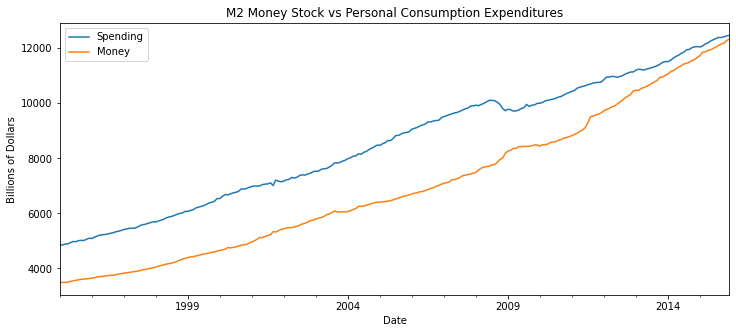

In [20]:
title = 'M2 Money Stock vs Personal Consumption Expenditures'
ylabel = 'Billions of Dollars'
xlabel = ''
ax = df['Spending'].plot(legend=True, title=title)
ax.autoscale(axis='x', tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
df['Money'].plot(legend=True)
plt.show()

In [21]:
# Augmented Dickey-Fuller Test
def adf_test(series, title=''):
    '''
    Hypothesis Test for Stationarity
    Pass in a time series and an optional title, return an ADF report
    '''
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC')
    labels = ['ADF test statistics','p-value','#lags','#observations'] # use help(adfuller) to understand why these labels are chosen
    
    outcome = pd.Series(result[0:4],index=labels)
    
    for key,val in result[4].items():
        outcome[f'critical value ({key})'] = val
        
    print(outcome.to_string()) # this will not print the line 'dtype:float64'
    
    if result[1] <= 0.05:
        print('Strong evidence against the null hypothesis') # Ho is Data is not stationary, check help(adfuller)
        print('Reject the null hypothesis')
        print('Data is Stationary')
    else:
        print('Weak evidence against the Null hypothesis')
        print('Fail to reject the null hypothesis')
        print('Data has a unit root and is non stationary')

In [23]:
adf_test(df['Money'])

Augmented Dickey-Fuller Test: 
ADF test statistics       4.239022
p-value                   1.000000
#lags                     4.000000
#observations           247.000000
critical value (1%)      -3.457105
critical value (5%)      -2.873314
critical value (10%)     -2.573044
Weak evidence against the Null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non stationary


In [25]:
adf_test(df['Spending'])

Augmented Dickey-Fuller Test: 
ADF test statistics       0.149796
p-value                   0.969301
#lags                     3.000000
#observations           248.000000
critical value (1%)      -3.456996
critical value (5%)      -2.873266
critical value (10%)     -2.573019
Weak evidence against the Null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non stationary


Take the first order difference of the entire dataframe and re-run the dickey fuller test

In [32]:
df_diff = df.diff()

In [35]:
df_diff.head()

,Money,Spending
Date,,
1995-01-01,NaN,NaN
1995-02-01,-2.5,-0.4
1995-03-01,1.2,34.6
1995-04-01,8.1,4.8
1995-05-01,25.0,42.9


In [37]:
# Drop the missing value row
df_diff = df_diff.dropna()
df_diff.head()

,Money,Spending
Date,,
1995-02-01,-2.5,-0.4
1995-03-01,1.2,34.6
1995-04-01,8.1,4.8
1995-05-01,25.0,42.9
1995-06-01,24.7,44.4


In [39]:
adf_test(df_diff['Money'], title='Money 1st Order Diff')

Augmented Dickey-Fuller Test: Money 1st Order Diff
ADF test statistics      -2.057404
p-value                   0.261984
#lags                    15.000000
#observations           235.000000
critical value (1%)      -3.458487
critical value (5%)      -2.873919
critical value (10%)     -2.573367
Weak evidence against the Null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non stationary


In [41]:
adf_test(df_diff['Spending'], title='Spending 1st Order Diff')

Augmented Dickey-Fuller Test: Spending 1st Order Diff
ADF test statistics    -7.226974e+00
p-value                 2.041027e-10
#lags                   2.000000e+00
#observations           2.480000e+02
critical value (1%)    -3.456996e+00
critical value (5%)    -2.873266e+00
critical value (10%)   -2.573019e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data is Stationary


In [43]:
# SInce one of the series is still not stationary, we will take the second order difference of both series so that they retain the same shape
df_diff = df_diff.diff().dropna()
adf_test(df_diff['Money'], title='Money 2nd Order Diff')

Augmented Dickey-Fuller Test: Money 2nd Order Diff
ADF test statistics    -7.077471e+00
p-value                 4.760675e-10
#lags                   1.400000e+01
#observations           2.350000e+02
critical value (1%)    -3.458487e+00
critical value (5%)    -2.873919e+00
critical value (10%)   -2.573367e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data is Stationary


In [44]:
adf_test(df_diff['Spending'], title='Spending 2nd Order Diff')

Augmented Dickey-Fuller Test: Spending 2nd Order Diff
ADF test statistics    -8.760145e+00
p-value                 2.687900e-14
#lags                   8.000000e+00
#observations           2.410000e+02
critical value (1%)    -3.457779e+00
critical value (5%)    -2.873609e+00
critical value (10%)   -2.573202e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data is Stationary


In [45]:
# Now both correlated features are stationary.
df_diff.head()

,Money,Spending
Date,,
1995-03-01,3.7,35.0
1995-04-01,6.9,-29.8
1995-05-01,16.9,38.1
1995-06-01,-0.3,1.5
1995-07-01,-6.2,-51.7


In [46]:
len(df_diff)

250

In [47]:
# Train Test Split
nobs = 12
train = df_diff[:-nobs]
test = df_diff[-nobs:]
len(train), len(test)

(238, 12)

### VAR Model Order Selection

In [61]:
p = [1,2,3,4,5,6,7] # try with list of 7 p values
aic, bic = [], []
for i in p:
    model = VAR(train)
    results = model.fit(i)
    aic.append(results.aic)
    bic.append(results.bic)
    print(f'VAR Order {i}')
    print('AIC: {}'.format(results.aic))
    print('BIC: {}'.format(results.bic))
    print()

min_aic = min(aic)
min_aic_index = aic.index(min_aic) + 1
min_bic = min(bic)
min_bic_index = bic.index(min_bic) + 1
print('Order {0} has the least AIC value. Let us select p = {0} in the modelling'.format(min_aic_index))


VAR Order 1
AIC: 14.178610495220896
BIC: 14.266409486135709

VAR Order 2
AIC: 13.955189367163703
BIC: 14.101961901274956

VAR Order 3
AIC: 13.849518291541038
BIC: 14.055621258341116

VAR Order 4
AIC: 13.827950574458281
BIC: 14.093744506408875

VAR Order 5
AIC: 13.78730034460964
BIC: 14.113149468980652

VAR Order 6
AIC: 13.799076756885809
BIC: 14.185349048538068

VAR Order 7
AIC: 13.797638727913972
BIC: 14.244705963046671

Order 5 has the least AIC value. Let us select p = 5 in the modelling


In [62]:
# let's confirm that both the variables are included in the model
model.endog_names

['Money', 'Spending']

### Fit the VAR(5) model

In [63]:
results = model.fit(min_aic_index)
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 23, Apr, 2023
Time:                     19:25:24
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    14.1131
Nobs:                     233.000    HQIC:                   13.9187
Log likelihood:          -2245.45    FPE:                    972321.
AIC:                      13.7873    Det(Omega_mle):         886628.
--------------------------------------------------------------------
Results for equation Money
                 coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------
const               0.516683         1.782238            0.290           0.772
L1.Money           -0.646232         0.068177           -9.479           0.000
L1.Spending        -0.107411         0.051388           -2.090      

### Predict the next 12 values

In [64]:
# For predictions, VAR model uses .forecast() instead of predictions.
lag_order = results.k_ar
lag_order

5

In [65]:
z = results.forecast(y=train.values[-lag_order:], steps = 12)
z

array([[-16.99527634,  36.14982003],
       [ -3.17403756, -11.45029844],
       [ -0.377725  ,  -6.68496939],
       [ -2.60223305,   5.47945777],
       [  4.228557  ,  -2.44336505],
       [  1.55939341,   0.38763902],
       [ -0.99841027,   3.88368011],
       [  0.36451042,  -2.3561014 ],
       [ -1.21062726,  -1.22414652],
       [  0.22587712,   0.786927  ],
       [  1.33893884,   0.18097449],
       [ -0.21858453,   0.21275046]])

In [66]:
test

,Money,Spending
Date,,
2015-01-01,-15.5,-26.6
2015-02-01,56.1,52.4
2015-03-01,-102.8,39.5
2015-04-01,30.9,-40.4
2015-05-01,-15.8,38.8
2015-06-01,14.0,-34.1
2015-07-01,6.7,6.9
2015-08-01,-0.7,-8.5
2015-09-01,5.5,-39.8


In [70]:
idx = pd.date_range(start='1/1/2015', periods=12, freq='MS')
df_forecast = pd.DataFrame(z, index=idx, columns=['Money2D', 'Spending2D'])
df_forecast[:5]

,Money2D,Spending2D
2015-01-01,-16.995276,36.149820
2015-02-01,-3.174038,-11.450298
2015-03-01,-0.377725,-6.684969
2015-04-01,-2.602233,5.479458
2015-05-01,4.228557,-2.443365


### Invert the Transformations

In [71]:
df_forecast['Money1D'] = (df['Money'].iloc[-nobs-1] - df['Money'].iloc[-nobs-2]) + df_forecast['Money2D'].cumsum()

In [78]:
# Now build the forecast values from the first difference set
df_forecast['MoneyForecast'] = df['Money'].iloc[-nobs-1] + df_forecast['Money1D'].cumsum()
df_forecast

,Money2D,Spending2D,Money1D,MoneyFOrecast,Spending1D,SpendingForecast,MoneyForecast
2015-01-01,-16.995276,36.149820,61.604724,11731.704724,46.749820,12108.749820,11731.704724
2015-02-01,-3.174038,-11.450298,58.430686,11790.135410,35.299522,12144.049342,11790.135410
2015-03-01,-0.377725,-6.684969,58.052961,11848.188371,28.614552,12172.663894,11848.188371
2015-04-01,-2.602233,5.479458,55.450728,11903.639099,34.094010,12206.757904,11903.639099
2015-05-01,4.228557,-2.443365,59.679285,11963.318384,31.650645,12238.408549,11963.318384
2015-06-01,1.559393,0.387639,61.238678,12024.557062,32.038284,12270.446833,12024.557062
2015-07-01,-0.998410,3.883680,60.240268,12084.797331,35.921964,12306.368797,12084.797331
2015-08-01,0.364510,-2.356101,60.604779,12145.402109,33.565863,12339.934659,12145.402109
2015-09-01,-1.210627,-1.224147,59.394151,12204.796261,32.341716,12372.276375,12204.796261
2015-10-01,0.225877,0.786927,59.620028,12264.416289,33.128643,12405.405019,12264.416289


In [79]:
# Similarly, let's do this for the spending column
# Add the most recent first difference from the training side of the original dataset to the forecast cumulative sum
df_forecast['Spending1D'] = (df['Spending'].iloc[-nobs-1]-df['Spending'].iloc[-nobs-2]) + df_forecast['Spending2D'].cumsum()

# Now build the forecast values from the first difference set
df_forecast['SpendingForecast'] = df['Spending'].iloc[-nobs-1] + df_forecast['Spending1D'].cumsum()
df_forecast

,Money2D,Spending2D,Money1D,MoneyFOrecast,Spending1D,SpendingForecast,MoneyForecast
2015-01-01,-16.995276,36.149820,61.604724,11731.704724,46.749820,12108.749820,11731.704724
2015-02-01,-3.174038,-11.450298,58.430686,11790.135410,35.299522,12144.049342,11790.135410
2015-03-01,-0.377725,-6.684969,58.052961,11848.188371,28.614552,12172.663894,11848.188371
2015-04-01,-2.602233,5.479458,55.450728,11903.639099,34.094010,12206.757904,11903.639099
2015-05-01,4.228557,-2.443365,59.679285,11963.318384,31.650645,12238.408549,11963.318384
2015-06-01,1.559393,0.387639,61.238678,12024.557062,32.038284,12270.446833,12024.557062
2015-07-01,-0.998410,3.883680,60.240268,12084.797331,35.921964,12306.368797,12084.797331
2015-08-01,0.364510,-2.356101,60.604779,12145.402109,33.565863,12339.934659,12145.402109
2015-09-01,-1.210627,-1.224147,59.394151,12204.796261,32.341716,12372.276375,12204.796261
2015-10-01,0.225877,0.786927,59.620028,12264.416289,33.128643,12405.405019,12264.416289


### Plot the results

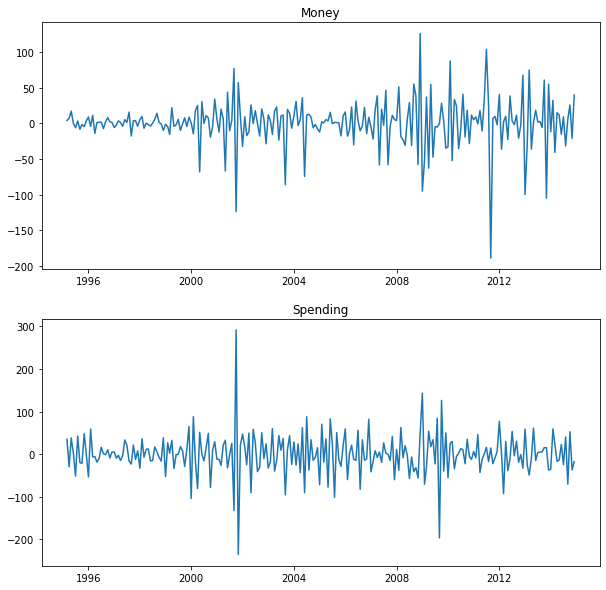

In [80]:
results.plot();

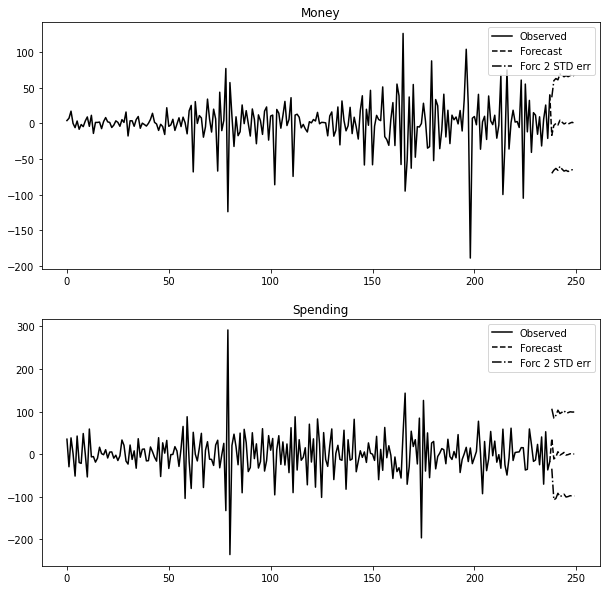

In [81]:
results.plot_forecast(12);

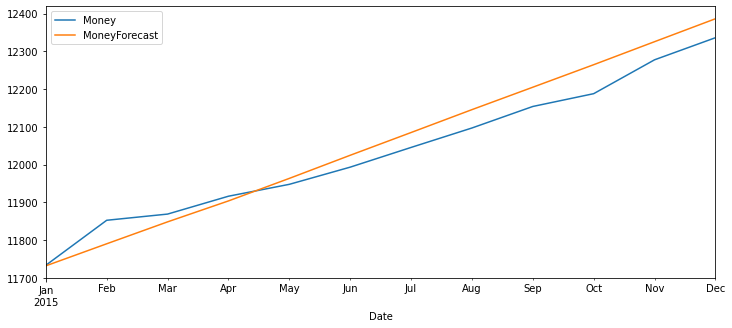

In [82]:
df['Money'][-nobs:].plot(figsize=(12,5),legend=True).autoscale(axis='x',tight=True)
df_forecast['MoneyForecast'].plot(legend=True);

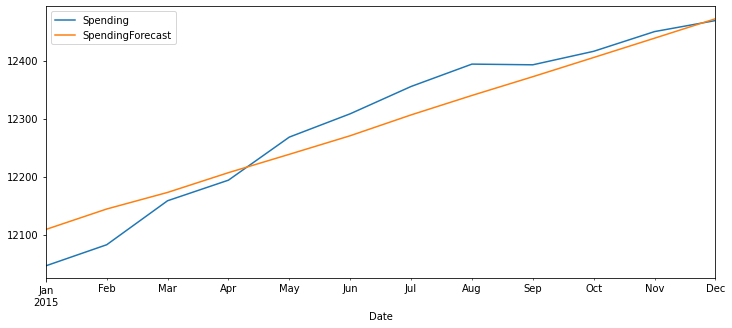

In [83]:
df['Spending'][-nobs:].plot(figsize=(12,5),legend=True).autoscale(axis='x',tight=True)
df_forecast['SpendingForecast'].plot(legend=True);

### Model Evaluation

In [84]:
RMSE1 = rmse(df['Money'][-nobs:], df_forecast['MoneyForecast'])
print(f'Money VAR(5) RMSE: {RMSE1:.3f}')

Money VAR(5) RMSE: 43.710


In [85]:
RMSE2 = rmse(df['Spending'][-nobs:], df_forecast['SpendingForecast'])
print(f'Spending VAR(5) RMSE: {RMSE2:.3f}')

Spending VAR(5) RMSE: 37.001


In [1]:
print("Except")

Except
